In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from surprise import SVD, KNNBasic
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise.reader import Reader

In [3]:
data = Dataset.load_builtin('ml-100k', prompt = False)

Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /home/houbr/.surprise_data/ml-100k


In [4]:
from surprise import BaselineOnly
bsl_options = {'method': 'sgd',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...


{'test_rmse': array([0.95531459, 0.96316563, 0.95892589]),
 'fit_time': (0.3186800479888916, 0.15973806381225586, 0.1464223861694336),
 'test_time': (0.3511078357696533, 0.4431924819946289, 0.22075414657592773)}

> Question: Change the method parameter by replacing sgd by als. Is the rms improving?

In [7]:
#answer
from surprise import BaselineOnly
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([0.94558253, 0.94242038, 0.9453064 ]),
 'fit_time': (0.10826706886291504, 0.12267184257507324, 0.18092870712280273),
 'test_time': (0.19828057289123535, 0.11392521858215332, 0.2037487030029297)}

=> the rms is not improving, but it took less time than SGD

In [8]:

# Let's use SVD seen in the course.
algo = SVD()
#  5-fold cross-validation showing results 
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9410  0.9328  0.9357  0.9378  0.9350  0.9364  0.0028  
MAE (testset)     0.7421  0.7343  0.7374  0.7392  0.7361  0.7378  0.0027  
Fit time          1.07    1.03    1.01    1.02    1.01    1.03    0.02    
Test time         0.12    0.10    0.10    0.10    0.10    0.11    0.01    


{'test_rmse': array([0.94103481, 0.93275182, 0.93565782, 0.93779242, 0.93497388]),
 'test_mae': array([0.74213082, 0.73432645, 0.7373885 , 0.73923223, 0.73610221]),
 'fit_time': (1.0696797370910645,
  1.0260512828826904,
  1.0126805305480957,
  1.0151383876800537,
  1.007152795791626),
 'test_time': (0.12108063697814941,
  0.10451674461364746,
  0.10069727897644043,
  0.09929466247558594,
  0.10394454002380371)}

## this SVD  is said to be biased:
https://surprise.readthedocs.io/en/stable/matrix_factorization.html#matrix-factorization-based-algorithms

## we will specify the optimal number of factors using GreadSearchCV.

In [9]:
param_grid = {'n_factors': [4,6,9,11,14,18,29]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
gs.fit(data)


# the best RMSE
print(gs.best_score['rmse'])

# parameters behind this performance
print(gs.best_params['rmse'])

0.9347797020475473
{'n_factors': 29}


## To get this number of factors in a more concise way, we will use cross-validation by proving it graphically 

In [10]:
def rmse_vs_factors(algorithm, data):
    
   
  
    rmse_algorithm = []
  
    for k in range(4,20,1):
        algo = algorithm(n_factors = k)
    
        #["test_rmse"] is a numpy array with the min RMSE in each test set
        loss_fce = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)["test_rmse"].mean() 
        rmse_algorithm.append(loss_fce)
        
    return rmse_algorithm

In [11]:
rmse_svd = rmse_vs_factors(SVD,data)

In [12]:
def plot_rmse(rmse, algorithm):
    plt.figure(num=None, figsize=(11, 5), dpi=80, facecolor='w', edgecolor='k')

    plt.subplot(2,1,1)
    plt.plot(rmse)
    plt.xlim(0,20)
    plt.title("{0} Performance: RMSE contre le nbre de Facteurs".format(algorithm), size = 20 )
    plt.ylabel("Mean RMSE (cv=5)")

    plt.subplot(2,1,2)
    plt.plot(rmse)
    plt.xlim(0,20)
    plt.xticks(np.arange(0, 20, step=2))

    plt.xlabel("{0}(facteur = k)".format(algorithm))
    plt.ylabel("Mean RMSE (cv=5)")
    plt.axvline(np.argmin(rmse), color = "r")
  
  

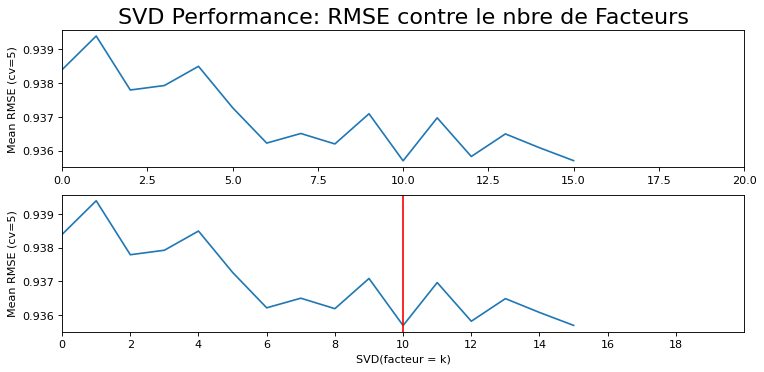

In [13]:
plot_rmse(rmse_svd,"SVD")

### Questions: 

the different parameters of the SVD: https://surprise.readthedocs.io/en/stable/matrix_factorization.html#matrix-factorization-based-algorithms
also: https://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly

1. Using GridSearchCV show the best combination of parameters for the baselineonly version
2. Using GridSearchCV, display the best combination of parameters for the biased version
3. Same question for the unbiased version
4. redo the same work (i.e., 1 and 2 and 3) using RandomizedSearchCV 

In [19]:
#Using GridSearchCV show the best combination of parameters for the baselineonly version

# Parameter grid for BaselineOnly
param_grid_baseline = {
    'bsl_options': {
        'method': ['als', 'sgd'],
        'reg': [0.02, 0.05, 0.1],
        'learning_rate': [0.005, 0.01, 0.02],
    }
}

# Parameter grid for Biased version
param_grid_biased = {
    'biased': [True],
    'bsl_options': {
        'method': ['als', 'sgd'],
        'reg': [0.02, 0.05, 0.1],
        'learning_rate': [0.005, 0.01, 0.02],
    }
}

# Parameter grid for Unbiased version
param_grid_unbiased = {
    'biased': [False],
    'bsl_options': {
        'method': ['als', 'sgd'],
        'reg': [0.02, 0.05, 0.1],
        'learning_rate': [0.005, 0.01, 0.02],
    }
}

# Define the algorithm objects
algo_baseline = BaselineOnly()
algo_biased = SVD()
algo_unbiased = SVD()

# GridSearchCV for BaselineOnly
gs_baseline = GridSearchCV(algo_baseline, param_grid_baseline, measures=['rmse'], cv=3)
gs_baseline.fit(data)

# GridSearchCV for Biased version
gs_biased = GridSearchCV(algo_biased, param_grid_biased, measures=['rmse'], cv=3)
gs_biased.fit(data)

# GridSearchCV for Unbiased version
gs_unbiased = GridSearchCV(algo_unbiased, param_grid_unbiased, measures=['rmse'], cv=3)
gs_unbiased.fit(data)


TypeError: 'BaselineOnly' object is not callable

In [ ]:
# Best combination of parameters for BaselineOnly
print("Best parameters for BaselineOnly:")
print(gs_baseline.best_params['rmse'])

# Best combination of parameters for Biased version
print("Best parameters for Biased version:")
print(gs_biased.best_params['rmse'])

# Best combination of parameters for Unbiased version
print("Best parameters for Unbiased version:")
print(gs_unbiased.best_params['rmse'])
